# Network Analysis of Publications on Studies of Parkinson Disease

## Data collection and preprocessing

The Microsoft Academic search engine was used to access the data. Firstly, information about publications for 2015-2021 which contained both words 'parkinson' and 'disease' in title or annotation was downloaded. This time interval was chosen to find out the main interests of scientists and trends in recent years.

There are many [attributes](https://docs.microsoft.com/en-us/academic-services/project-academic-knowledge/reference-paper-entity-attributes) of the paper that company provides for downloading. In this work we use only this attributes:

- Id - Paper ID
- Ti - Normalized title
- W - Unique, normalized words in title	
- AW - Unique, normalized words in abstract, excluding common/stopwords
- Y - Year published
- CC - Citation count
- RId - List of referenced paper IDs
- DN - Original paper title
- DOI - Digital Object Identifier
- IA - Inverted abstract {IndexLength - Number of items in the index (abstract's word count), InvertedIndex - List of abstract words and their corresponding position in the original abstract }
- AA.AfId	- Author affiliation ID	
- AA.AfN - Author affiliation name
- AA.AuId	- Author ID
- AA.AuN - Normalized author name	
- AA.DAuN	- Original author name	
- AA.DAfN	- Original affiliation name
- J.JId - Journal ID
- J.JN - Journal name
- D - Date published in YYYY-MM-DD format

Date of access to the database: 20.11.2021

The main Pyhon libraries that were used to analyse data:

In [1]:
import pandas as pd
import ast
from ast import literal_eval
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import rcParams
warnings.filterwarnings('ignore')

Data downloading:

In [22]:
import http.client, urllib.request, urllib.parse, urllib.error, base64, json, httplib2, urllib

headers = {
    'Ocp-Apim-Subscription-Key': '205b33891e4c4bab9f5fc93cf431e32c',
}
offset = 0
count = 1000

all_data = pd.DataFrame()
i = 0

while(1):
    params = urllib.parse.urlencode({
        'model': 'latest',
        'attributes': 'Ti,DN,AA.DAuN,AA.DAfN,AA.AuN,Y,CC,Id,RId,AW,DOI,J.JId,J.JN,W,AW,IA,AA.AfId,AA.AfN,AA.AuId,D',
        'count': f'{count}',
        'offset': f'{offset}',
        'timeout': '10',
    })
    try:
        conn = http.client.HTTPSConnection('api.labs.cognitive.microsoft.com')
        conn.request("GET", "/academic/v1.0/evaluate?expr=And(Or(And(W='parkinson',W='disease'),And(AW='parkinson',AW='disease')),Y=[2015,2021])&%s" % params, "{body}", headers)

        response = conn.getresponse()
        data = response.read()

        data1 = json.loads(data)

        data1 = data1['entities']

        tmp = pd.DataFrame(data1)

        if tmp.empty:
            break
        all_data = pd.concat([all_data, tmp])

        conn.close()
    except Exception as e:
        print("[Errno {0}] {1}".format(e.errno, e.strerror))
        break
    offset += count
    i+=1

In [34]:
all_data.drop(['logprob', 'prob'], axis = 1, inplace = True)

In [73]:
all_data = all_data.drop_duplicates('Id')
all_data.reset_index(drop = True, inplace = True)

In [75]:
all_data.to_csv('parkinson_data.csv', sep = ';', index = False)

Fuction that reads data from a csv file and converts information in 'AA' (all about authors) and 'W' (words in title) columns from string to list format

In [2]:
def read_data(path, sep):
    df = pd.read_csv(path, sep=sep)
    df.loc[:, 'AA'] = df['AA'].apply(lambda x: ast.literal_eval(x))
    df.loc[:, 'W'] = df['W'].apply(lambda x: ast.literal_eval(x))
    return df

In [3]:
df = read_data('parkinson_data.csv', ';')

In [4]:
print('Total number of articles:', df.shape[0])

Total number of articles: 70119


There are some publications without DOI, so we can divide them into different files. In the further analysis only articles with DOI will be used

In [97]:
no_doi_data = df.loc[df['DOI'].isna()]
with_doi_data = df.loc[df['DOI'].isna() == False]
no_doi_data.reset_index(drop = True, inplace = True)
with_doi_data.reset_index(drop = True, inplace = True)
no_doi_data.to_csv('no_doi.csv', sep = ';', index = False)
with_doi_data.to_csv('with_doi.csv', sep = ';', index = False)

In [5]:
no_doi_data = read_data('no_doi.csv', sep = ';')
with_doi_data = read_data('with_doi.csv', sep = ';')

In [6]:
print('With DOI:', with_doi_data.shape[0])
print('Without DOI:', no_doi_data.shape[0])

With DOI: 59438
Without DOI: 10681


There are also some articles with DOI and without abstract, journal. In the further analysis only articles with DOI, abstract and journal will be used

In [ ]:
no_annotation = with_doi_data[with_doi_data['AW'].isna()]
no_annotation.to_csv('no_annotation.csv', sep = ';', index = False)
with_doi_annotation = with_doi_data[with_doi_data['AW'].isna() == False]
with_doi_annotation.reset_index(inplace=True, drop=True)
with_doi_annotation.to_csv('with_doi_annotation.csv', sep = ';', index = False)

In [8]:
with_doi_annotation = read_data('with_doi_annotation.csv', ';')

In [11]:
print('With DOI and without abstract :', with_doi_data[with_doi_data['AW'].isna()].count()['Id'])
print('With DOI and abstract :', with_doi_data[with_doi_data['AW'].isna() == False].count()['Id'])
print('With DOI, abstract and without journal:', with_doi_annotation[with_doi_annotation['J'].isna()].count()['Id'])
print('With DOI, abstract and journal:', with_doi_annotation[with_doi_annotation['J'].isna() == False].count()['Id'])

With DOI and without abstract : 7315
With DOI and abstract : 52123
With DOI, abstract and without journal: 6183
With DOI, abstract and journal: 45940


In [12]:
with_doi_annotation_journals = with_doi_annotation[with_doi_annotation['J'].isna() == False]
with_doi_annotation_journals.to_csv('with_doi_annotation_journals.csv', sep = ';', index = False)

In [19]:
print('The number of articles with DOI, abstract and journal in each year')
pd.DataFrame(with_doi_annotation_journals['Y'].value_counts()).rename(columns ={'Y':'Cnt'})

The number of articles with DOI, abstract and journal in each year


,Cnt
2021,8074
2020,7549
2019,6594
2017,6249
2018,5922
2016,5892
2015,5660


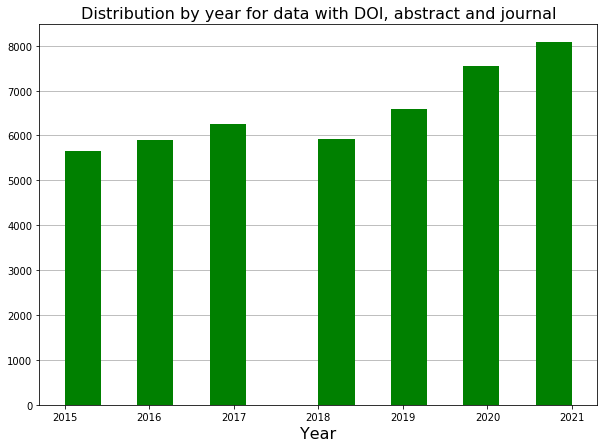

In [21]:
plt.rcParams['figure.figsize'] = 10, 7
plt.title('Distribution by year for data with DOI, abstract and journal', fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.grid(axis = 'y', which = 'both', zorder = 0)
plt.hist(with_doi_annotation_journals['Y'], bins = 14, color = 'green', rwidth = 1, align = 'mid', zorder = 3)
mpl.rcParams['savefig.format'] = 'pdf'
plt.savefig('distribution.png')
plt.show()

Descriptive statistics for CC - citation count

In [24]:
with_doi_annotation_journals.groupby('Y')['CC'].describe()

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
2015,5660.0,30.313958,59.909328,0.0,6.0,16.0,35.0,2014.0
2016,5892.0,25.807536,45.867736,0.0,5.0,14.0,31.0,1347.0
2017,6249.0,23.293487,44.403213,0.0,5.0,13.0,26.0,1535.0
2018,5922.0,18.264100,31.609280,0.0,4.0,10.0,21.0,790.0
2019,6594.0,12.939339,21.956273,0.0,3.0,7.0,15.0,497.0
2020,7549.0,6.207312,11.416934,0.0,1.0,3.0,7.0,285.0
2021,8074.0,1.291058,3.181336,0.0,0.0,0.0,1.0,94.0


In [25]:
cc = pd.DataFrame(with_doi_annotation_journals.groupby('Y').count()['CC'])
cc0 = pd.DataFrame(with_doi_annotation_journals[with_doi_annotation_journals['CC'] == 0].groupby('Y').count()['CC'])
cc0.rename(columns = {'CC':'CC = 0'}, inplace = True)
cc1 = pd.DataFrame(with_doi_annotation_journals[with_doi_annotation_journals['CC'] != 0].groupby('Y').count()['CC'])
cc1.rename(columns = {'CC':'CC > 0'}, inplace = True)
cc_stat = cc.join(cc0.join(cc1, on = 'Y'), on = 'Y')
cc_stat['CC = 0, %'] = cc_stat['CC = 0'] / cc_stat['CC'] * 100
cc_stat['CC > 0, %'] = cc_stat['CC > 0'] / cc_stat['CC'] * 100
cc_stat

,CC,CC = 0,CC > 0,"CC = 0, %","CC > 0, %"
Y,,,,,
2015,5660,515,5145,9.098940,90.901060
2016,5892,595,5297,10.098439,89.901561
2017,6249,554,5695,8.865418,91.134582
2018,5922,611,5311,10.317460,89.682540
2019,6594,752,5842,11.404307,88.595693
2020,7549,1389,6160,18.399788,81.600212
2021,8074,4718,3356,58.434481,41.565519
